In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import show_images, plot_predictions

In [2]:
data_dir = "data/plant_health"
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

In [3]:
img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=100,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' ## this is actually a validation split
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 150 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [5]:
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")

Class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [6]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

images, labels = next(train_generator)

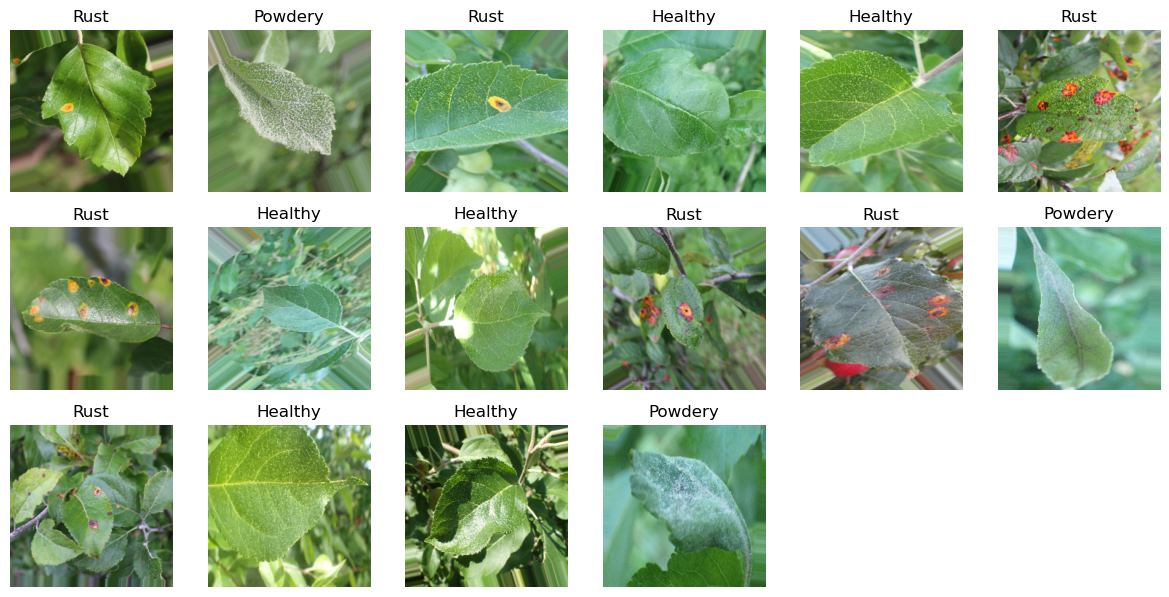

In [7]:
show_images(images, labels, class_names)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/20
10/10 [==============================] - 26s 2s/step - loss: 2.8426 - accuracy: 0.3533 - val_loss: 1.9355 - val_accuracy: 0.3333
Epoch 2/20
10/10 [==============================] - 21s 2s/step - loss: 1.7456 - accuracy: 0.3333 - val_loss: 1.5907 - val_accuracy: 0.3333
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 1.5266 - accuracy: 0.3333 - val_loss: 1.4375 - val_accuracy: 0.3333
Epoch 4/20
10/10 [==============================] - 23s 2s/step - loss: 1.3638 - accuracy: 0.3667 - val_loss: 1.2283 - val_accuracy: 0.6000
Epoch 5/20
10/10 [==============================] - 23s 2s/step - loss: 1.2339 - accuracy: 0.4200 - val_loss: 1.2174 - val_accuracy: 0.4667
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 1.1473 - accuracy: 0.4667 - val_loss: 1.1879 - val_accuracy: 0.4000
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 1.1854 - accuracy: 0.4867 - val_loss: 1.1917 - val_accuracy: 0.4000
Epoch 8/20
10/10 [==

In [11]:
model.evaluate(test_generator)

2/2 [==============================] - 3s 2s/step - loss: 0.9101 - accuracy: 0.6000


[0.9101099371910095, 0.6000000238418579]

In [12]:
transfer_layer = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_layer.trainable = False

In [13]:
transfer_model = tf.keras.Sequential([
    transfer_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [14]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
transfer_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/10
10/10 [==============================] - 29s 3s/step - loss: 7.1198 - accuracy: 0.4067 - val_loss: 3.0346 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 3.5960 - accuracy: 0.5333 - val_loss: 2.5303 - val_accuracy: 0.6000
Epoch 3/10
10/10 [==============================] - 26s 3s/step - loss: 3.0562 - accuracy: 0.5400 - val_loss: 2.1426 - val_accuracy: 0.7000
Epoch 4/10
10/10 [==============================] - 26s 3s/step - loss: 2.1810 - accuracy: 0.6800 - val_loss: 1.8159 - val_accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 25s 3s/step - loss: 1.9348 - accuracy: 0.7067 - val_loss: 1.5910 - val_accuracy: 0.8667
Epoch 6/10
10/10 [==============================] - 25s 3s/step - loss: 1.6673 - accuracy: 0.7667 - val_loss: 1.4573 - val_accuracy: 0.8667
Epoch 7/10
10/10 [==============================] - 26s 3s/step - loss: 1.4992 - accuracy: 0.7600 - val_loss: 1.3521 - val_accuracy: 0.8000
Epoch 8/10
10/10 [==

In [16]:
transfer_model.evaluate(test_generator)

2/2 [==============================] - 4s 2s/step - loss: 1.1608 - accuracy: 0.8333


[1.16083562374115, 0.8333333134651184]

In [17]:
## fine-tuning
transfer_layer.trainable = True

In [18]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


In [19]:
transfer_model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/20
10/10 [==============================] - 53s 5s/step - loss: 1.1985 - accuracy: 0.8067 - val_loss: 1.1343 - val_accuracy: 0.8333
Epoch 2/20
10/10 [==============================] - 48s 5s/step - loss: 1.1400 - accuracy: 0.7933 - val_loss: 0.9301 - val_accuracy: 0.9333
Epoch 3/20
10/10 [==============================] - 49s 5s/step - loss: 0.9926 - accuracy: 0.8733 - val_loss: 0.8012 - val_accuracy: 0.9667
Epoch 4/20
10/10 [==============================] - 48s 5s/step - loss: 0.9757 - accuracy: 0.8600 - val_loss: 0.7825 - val_accuracy: 0.9667
Epoch 5/20
10/10 [==============================] - 48s 5s/step - loss: 0.8983 - accuracy: 0.9200 - val_loss: 0.7469 - val_accuracy: 0.9667
Epoch 6/20
10/10 [==============================] - 48s 5s/step - loss: 0.9154 - accuracy: 0.9000 - val_loss: 0.7203 - val_accuracy: 0.9667
Epoch 7/20
10/10 [==============================] - 48s 5s/step - loss: 0.8110 - accuracy: 0.9533 - val_loss: 0.9671 - val_accuracy: 0.8333
Epoch 8/20
10/10 [==

In [20]:
transfer_model.evaluate(test_generator)

2/2 [==============================] - 4s 2s/step - loss: 0.6812 - accuracy: 0.9667


[0.6811752319335938, 0.9666666388511658]

1/1 [==============================] - 1s 1s/step


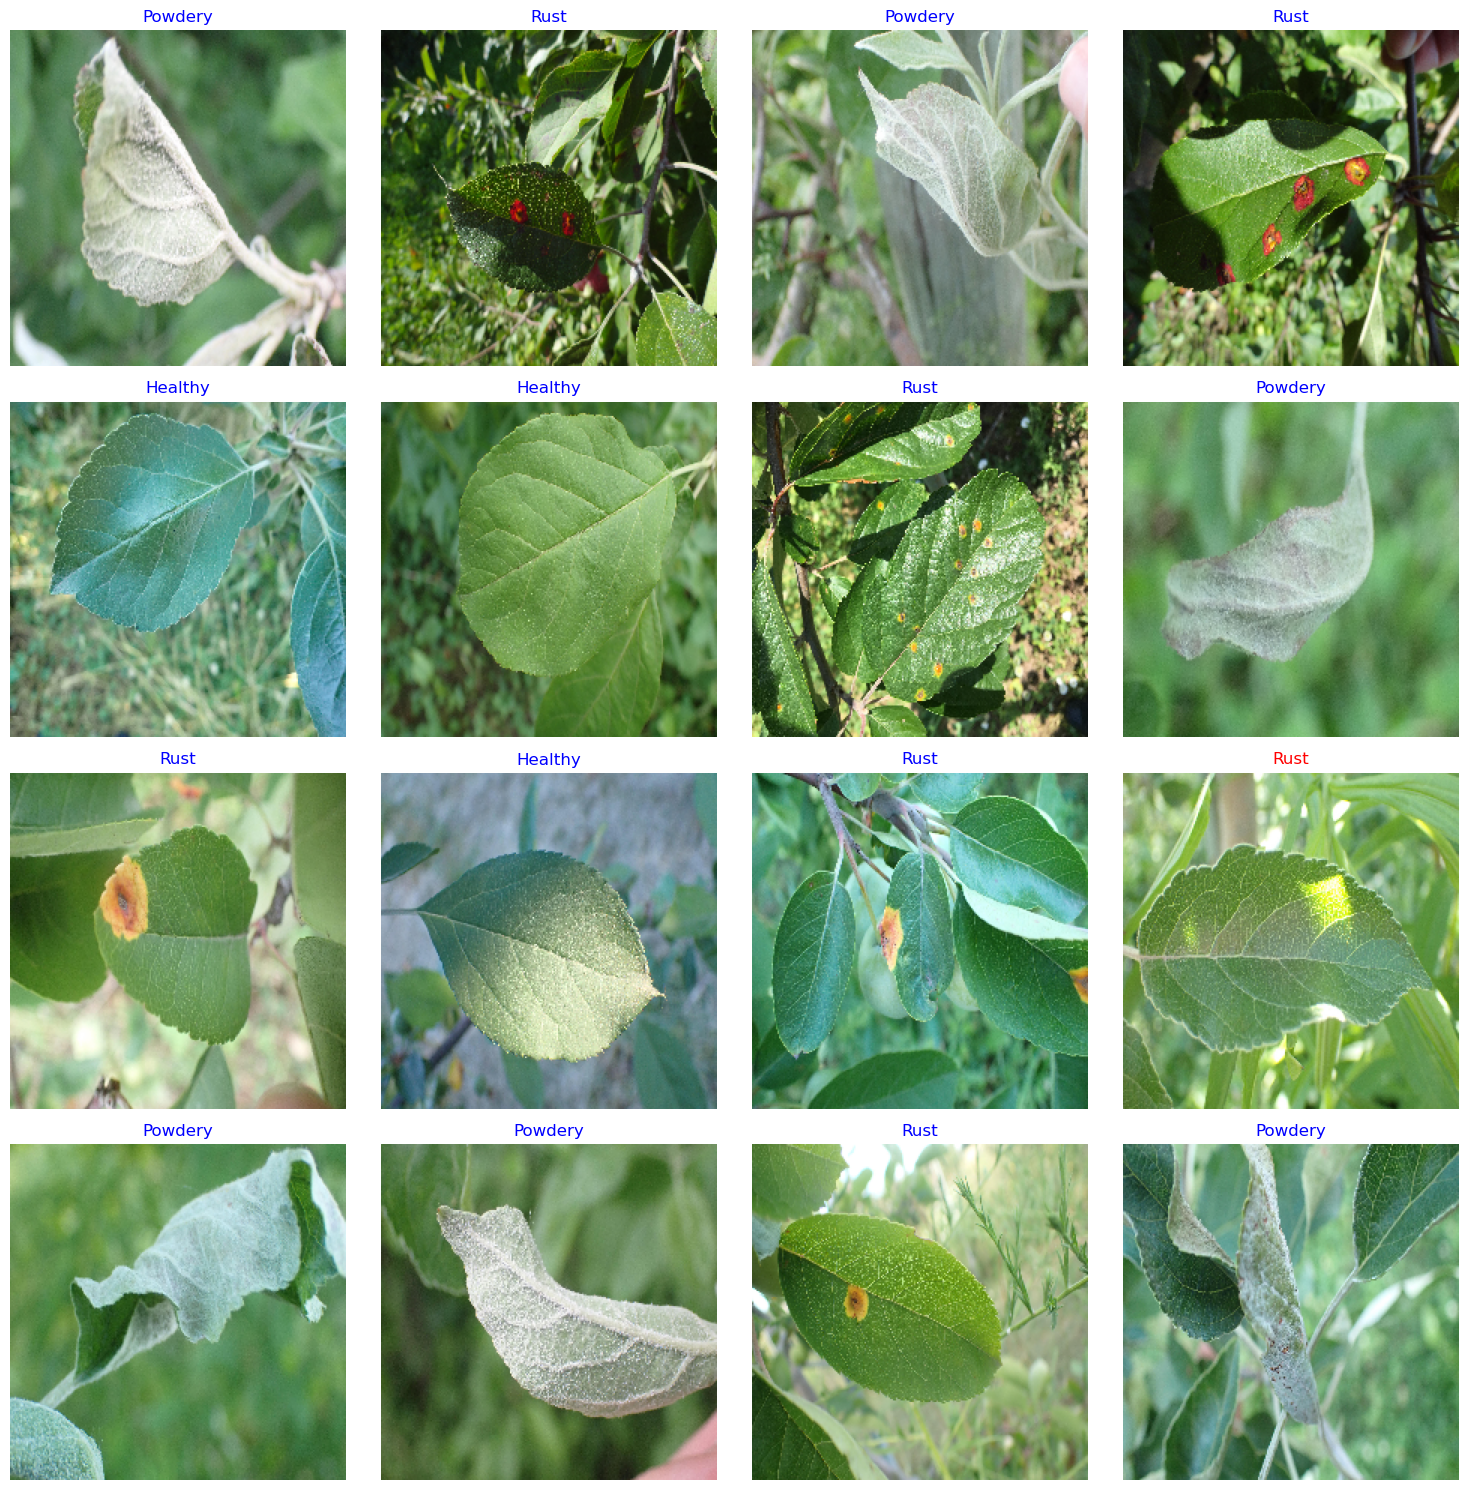

In [21]:
plot_predictions(test_generator, transfer_model, class_names)